# MNIST Classification Showdown

# 0. Imports and Datasets

In [2]:
# %pip install ml_collections
# %pip install flax
# %pip install bayesian-optimization
# %pip install -qq git+https://github.com/probml/rebayes.git
# %pip install jaxtyping
# %pip install jax-tqdm
# %pip install dynamax

In [4]:
from functools import partial
import time
from typing import Callable, Sequence
import collections.abc
import warnings
import copy
from collections import deque
from tqdm import trange

import ml_collections
import tensorflow_datasets as tfds
from tensorflow_probability.substrates.jax.distributions import MultivariateNormalFullCovariance as MVN
from tensorflow_probability.substrates.jax.distributions import MultivariateNormalDiag as MVND
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

from flax import linen as nn
from flax.training import train_state
import jax
from jax import jit, vmap, lax, jacfwd
from jax.flatten_util import ravel_pytree
import jax.numpy as jnp
import jax.random as jr
import optax
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from bayes_opt import BayesianOptimization

jax.numpy.set_printoptions(suppress = True, precision=4)
from rebayes.base import RebayesParams
from rebayes.low_rank_filter.lofi import LoFiParams, RebayesLoFi
from rebayes.extended_kalman_filter.ekf import RebayesEKF
import demos.showdown.hparam_tune_clf as hp

In [5]:
def get_datasets():
    """Load MNIST train and test datasets into memory."""
    ds_builder = tfds.builder('mnist')
    ds_builder.download_and_prepare()
    train_ds = tfds.as_numpy(ds_builder.as_dataset(split='train', batch_size=-1))
    train_tvsplit_ds = tfds.as_numpy(ds_builder.as_dataset(split='train[:80%]', batch_size=-1))
    val_tvsplit_ds = tfds.as_numpy(ds_builder.as_dataset(split='train[80%:]', batch_size=-1))
    test_ds = tfds.as_numpy(ds_builder.as_dataset(split='test', batch_size=-1))
    for ds in [train_ds, train_tvsplit_ds, val_tvsplit_ds, test_ds]:
        ds['image'] = jnp.float32(ds['image']) / 255.
    return train_ds, test_ds, train_tvsplit_ds, val_tvsplit_ds

In [6]:
train_ds, test_ds, train_tvsplit_ds, val_tvsplit_ds = get_datasets()

In [7]:
X_train, y_train = jnp.array(train_ds['image']), jnp.array(train_ds['label'])
X_test, y_test = jnp.array(test_ds['image']), jnp.array(test_ds['label'])

In [8]:
# Reshape data
X_train = X_train.reshape(-1, 1, 28, 28, 1)
y_train_ohe = jax.nn.one_hot(y_train, 10)

# 1. Models

In [9]:
class CNN(nn.Module):
    """A simple CNN model."""
    @nn.compact
    def __call__(self, x):
        x = nn.Conv(features=32, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = nn.Conv(features=64, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = x.reshape((x.shape[0], -1))  # flatten
        x = nn.Dense(features=128)(x)
        x = nn.relu(x)
        x = nn.Dense(features=10)(x)
        return x

class MLP(nn.Module):
    features: Sequence[int]

    @nn.compact
    def __call__(self, x):
        x = x.ravel()
        for feat in self.features[:-1]:
            x = nn.relu(nn.Dense(feat)(x))
        x = nn.Dense(self.features[-1])(x)
        return x

In [10]:
cnn = CNN()
key = jr.PRNGKey(0)
params = cnn.init(key, jnp.ones([1, 28, 28, 1]))['params']
flat_params, unflatten_fn = ravel_pytree(params)
print(f'Params size = {flat_params.shape}')
state_dim = flat_params.shape[0]

Params size = (421642,)


In [11]:
apply_fn = lambda w, x: cnn.apply({'params': unflatten_fn(w)}, x).ravel()
emission_mean_function=lambda w, x: jax.nn.softmax(apply_fn(w, x))
def emission_cov_function(w, x):
    ps = emission_mean_function(w, x)
    return jnp.diag(ps) - jnp.outer(ps, ps) + 1e-3 * jnp.eye(len(ps)) # Add diagonal to avoid singularity

In [12]:
test_kwargs = {'test': test_ds, 'unflatten_fn': unflatten_fn, 'apply_fn': apply_fn}

In [13]:
def evaluate_neg_log_likelihood(flat_params, unflatten_fn, apply_fn, test_set):
    """ Evaluate negative log likelihood for given parameters and test set
    """
    @jit
    def evaluate_nll(label, image):
        image = image.reshape((1, 28, 28, 1))
        logits = apply_fn(flat_params, image)
        return optax.softmax_cross_entropy_with_integer_labels(logits=logits, labels=label)
    nlls = vmap(evaluate_nll, (0, 0))(test_set['label'], test_set['image'])
    return nlls.mean()

In [14]:
def ll_callback(bel, *args, **kwargs):
    test_set = kwargs["test"]
    unflatten_fn, apply_fn = kwargs["unflatten_fn"], kwargs["apply_fn"]
    ll = -evaluate_neg_log_likelihood(bel.mean, unflatten_fn, apply_fn, test_set)
    return ll

In [15]:
def get_config(
    optimizer='sgd',
    learning_rate=0.01, 
    momentum=2e-1,
    init_var=3e-2,
    num_iter=1,
    batch_size=1, 
    num_epochs=1,
    sample_freq=500,
    posterior_predictive_method='mc',
    seed=0
    ):
    """Get the default hyperparameter configuration."""
    config = ml_collections.ConfigDict()
    config.optimizer = optimizer
    config.learning_rate = learning_rate
    config.momentum = momentum
    config.init_var = init_var
    config.num_iter = num_iter
    config.batch_size = batch_size
    config.num_epochs = num_epochs
    config.sample_freq = sample_freq
    config.posterior_predictive_method = posterior_predictive_method
    config.seed = seed
    return config

# 2. Orth-SVD LoFi

## 2.1 Hyperparam Tuning

In [29]:
def lofi_opt_fn(X, y, log_init_cov, log_dynamics_cov, log_alpha, memory_size, method='orth_svd_lofi'):
    model_params = RebayesParams(
        initial_mean=flat_params,
        initial_covariance=jnp.power(10, log_init_cov),
        dynamics_weights=1.0,
        dynamics_covariance=jnp.power(10, log_dynamics_cov),
        emission_mean_function=emission_mean_function,
        emission_cov_function=emission_cov_function,
        dynamics_covariance_inflation_factor=jnp.power(10, log_alpha)
    )
    lofi_params = LoFiParams(
        memory_size=int(memory_size),
    )
    estimator = RebayesLoFi(model_params, lofi_params, method=method)

    test_kwargs = {'test': test_ds, 'unflatten_fn': unflatten_fn, 'apply_fn': apply_fn}
    bel, output = estimator.scan(X, y, callback=ll_callback, progress_bar=False, **test_kwargs)

    return output.mean()

In [ ]:
os_lofi_opt_fn = partial(lofi_opt_fn, X=X_train[:1000], y=y_train_ohe[:1000], 
                        memory_size=20, method='orth_svd_lofi')
os_lofi_optimizer = BayesianOptimization(
    f=os_lofi_opt_fn,
    pbounds={
        'log_init_cov': (-6, -0.1),
        'log_dynamics_cov': (-6, -0.1),
        'log_alpha': (-7, -0.1),
    }
)

In [ ]:
os_lofi_optimizer.maximize(
    init_points=30,
    n_iter=30,
)

|   iter    |  target   | log_alpha | log_dy... | log_in... |
-------------------------------------------------------------
| 1         | -2.302    | -0.815    | -4.139    | -5.025    |
| 2         | -1.866    | -3.291    | -5.577    | -2.577    |
| 3         | -1.178    | -3.329    | -4.791    | -2.052    |
| 4         | -2.303    | -3.788    | -3.728    | -5.839    |
| 5         | -0.9006   | -1.951    | -2.633    | -0.8505   |
| 6         | -2.242    | -1.883    | -4.945    | -3.148    |
| 7         | -0.8995   | -0.9756   | -4.73     | -1.067    |
| 8         | -0.9229   | -6.674    | -4.059    | -1.235    |
| 9         | -2.302    | -3.963    | -1.11     | -5.125    |
| 10        | -2.297    | -6.315    | -1.704    | -4.142    |
| 11        | -2.302    | -0.3816   | -4.241    | -5.497    |
| 12        | -2.206    | -3.101    | -4.308    | -2.979    |
| 13        | -1.983    | -4.727    | -1.992    | -2.659    |
| 14        | -2.302    | -4.3      | -4.61     | -5.411    |
| 15    

In [ ]:
# 'log_alpha': -3.365269365850155, 'log_dynamics_cov': -2.153208025936515, 'log_init_cov': -1.1271226233108633
print(os_lofi_optimizer.max)

{'target': -0.8867484331130981, 'params': {'log_alpha': -3.365269365850155, 'log_dynamics_cov': -2.153208025936515, 'log_init_cov': -1.1271226233108633}}


## 2.2 Test-Set NLL Evaluation

In [16]:
def evaluate_model(estimator, X, y, test_kwargs, key=0, n_steps=1_000, n_iter=10):
    if isinstance(key, int):
        key = jr.PRNGKey(key)

    def _step(_, key):
        indx = jr.choice(key, len(X), (n_steps,))
        X_curr, y_curr = X[indx], y[indx]
        _, lls = estimator.scan(X_curr, y_curr, callback=ll_callback, **test_kwargs)
        nlls = -1*lls
        return nlls, nlls
    
    keys = jr.split(key, n_iter)
    carry = jnp.zeros((n_steps,))
    _, nlls = lax.scan(_step, carry, keys)
    mean, std = nlls.mean(axis=0), nlls.std(axis=0)

    return mean, std

In [17]:
init_cov = jnp.power(10, -1.1271226233108633)
dynamics_cov = jnp.power(10, -2.153208025936515)
alpha = jnp.power(10, -3.365269365850155)
method = 'orth_svd_lofi'

model_params = RebayesParams(
    initial_mean=flat_params,
    initial_covariance=init_cov,
    dynamics_weights=1.0,
    dynamics_covariance=dynamics_cov,
    emission_mean_function=emission_mean_function,
    emission_cov_function=emission_cov_function,
    dynamics_covariance_inflation_factor=alpha
)
lofi_params = LoFiParams(
    memory_size=20,
)
os_lofi_estimator = RebayesLoFi(model_params, lofi_params, method=method)

In [18]:
os_lofi_mean, os_lofi_std = evaluate_model(os_lofi_estimator, X_train, y_train_ohe, test_kwargs)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

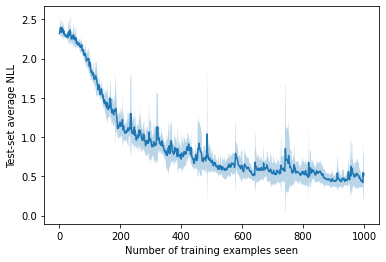

In [22]:
fig, ax = plt.subplots()
ax.plot(os_lofi_mean)
ax.fill_between(
    jnp.arange(os_lofi_mean.shape[0]),
    os_lofi_mean - os_lofi_std,
    os_lofi_mean + os_lofi_std,
    alpha=0.3
)
ax.set_xlabel('Number of training examples seen')
ax.set_ylabel('Test-set average NLL');

# 3. Full-SVD LoFi

## 3.1 Hyperparam Tuning

In [30]:
fs_lofi_opt_fn = partial(lofi_opt_fn, X=X_train[:1000], y=y_train_ohe[:1000], 
                        memory_size=20, method='full_svd_lofi')
fs_lofi_optimizer = BayesianOptimization(
    f=fs_lofi_opt_fn,
    pbounds={
        'log_init_cov': (-6, -0.1),
        'log_dynamics_cov': (-6, -0.1),
        'log_alpha': (-7, -0.1),
    }
)

In [31]:
fs_lofi_optimizer.maximize(
    init_points=20,
    n_iter=25,
)

|   iter    |  target   | log_alpha | log_dy... | log_in... |
-------------------------------------------------------------
| 1         | -2.302    | -6.914    | -1.532    | -5.23     |
| 2         | -2.299    | -1.725    | -5.595    | -4.333    |
| 3         | -0.6781   | -6.178    | -0.5507   | -0.9639   |
| 4         | -2.133    | -2.466    | -2.707    | -2.819    |
| 5         | -2.267    | -4.828    | -2.64     | -3.369    |
| 6         | -2.287    | -0.1264   | -4.375    | -3.733    |
| 7         | -0.7095   | -3.148    | -1.803    | -0.6341   |
| 8         | -2.301    | -4.591    | -1.05     | -4.813    |
| 9         | -2.303    | -3.138    | -4.494    | -5.828    |
| 10        | -2.302    | -3.02     | -2.17     | -5.542    |
| 11        | -0.9324   | -4.07     | -1.923    | -1.88     |
| 12        | -2.102    | -0.1627   | -0.3163   | -2.77     |
| 13        | -2.302    | -0.6108   | -5.387    | -5.331    |
| 14        | -2.303    | -1.368    | -3.759    | -5.703    |
| 15    

In [32]:
# 'log_alpha': -6.178173391151056, 'log_dynamics_cov': -0.5506521610089559, 'log_init_cov': -0.9638980933639827
print(fs_lofi_optimizer.max)

{'target': -0.6780857443809509, 'params': {'log_alpha': -6.178173391151056, 'log_dynamics_cov': -0.5506521610089559, 'log_init_cov': -0.9638980933639827}}


## 3.2 Test-Set NLL Evaluation

In [33]:
init_cov = jnp.power(10, -0.9638980933639827)
dynamics_cov = jnp.power(10, -0.5506521610089559)
alpha = jnp.power(10, -6.178173391151056)
method = 'full_svd_lofi'

model_params = RebayesParams(
    initial_mean=flat_params,
    initial_covariance=init_cov,
    dynamics_weights=1.0,
    dynamics_covariance=dynamics_cov,
    emission_mean_function=emission_mean_function,
    emission_cov_function=emission_cov_function,
    dynamics_covariance_inflation_factor=alpha
)
lofi_params = LoFiParams(
    memory_size=20,
)
fs_lofi_estimator = RebayesLoFi(model_params, lofi_params, method=method)

In [34]:
fs_lofi_mean, fs_lofi_std = evaluate_model(fs_lofi_estimator, X_train, y_train_ohe, test_kwargs)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

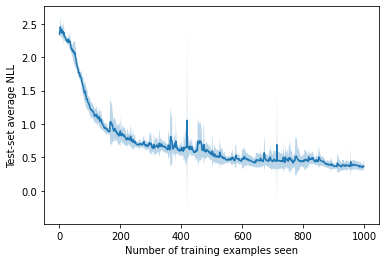

In [36]:
fig, ax = plt.subplots()
ax.plot(fs_lofi_mean)
ax.fill_between(
    jnp.arange(fs_lofi_mean.shape[0]),
    fs_lofi_mean - fs_lofi_std,
    fs_lofi_mean + fs_lofi_std,
    alpha=0.3
)
ax.set_xlabel('Number of training examples seen')
ax.set_ylabel('Test-set average NLL');

# 4. FD-EKF

## 4.1 Hyperparam Tuning

In [ ]:
def ekf_opt_fn(X, y, log_init_cov, log_dynamics_cov, log_alpha, method='fdekf'):
    model_params = RebayesParams(
        initial_mean=flat_params,
        initial_covariance=jnp.power(10, log_init_cov),
        dynamics_weights=1.0,
        dynamics_covariance=jnp.power(10, log_dynamics_cov),
        emission_mean_function=emission_mean_function,
        emission_cov_function=emission_cov_function,
        dynamics_covariance_inflation_factor=jnp.power(10, log_alpha)
    )
    estimator = RebayesEKF(model_params, method=method)

    test_kwargs = {'test': test_ds, 'unflatten_fn': unflatten_fn, 'apply_fn': apply_fn}
    bel, output = estimator.scan(X, y, callback=ll_callback, progress_bar=False, **test_kwargs)
    
    result = output.mean()
    if jnp.isnan(result):
        result = -1e6
    return result

In [ ]:
fdekf_opt_fn = partial(ekf_opt_fn, X=X_train[:1000], y=y_train_ohe[:1000], method='fdekf')
fdekf_optimizer = BayesianOptimization(
    f=fdekf_opt_fn,
    pbounds={
        'log_init_cov': (-6, -0.1),
        'log_dynamics_cov': (-6, -0.1),
        'log_alpha': (-7, -0.1),
    }
)

In [ ]:
fdekf_optimizer.maximize(
    init_points=30,
    n_iter=30,
)

|   iter    |  target   | log_alpha | log_dy... | log_in... |
-------------------------------------------------------------
| 1         | -2.128    | -5.693    | -5.443    | -3.658    |
| 2         | -1e+06    | -0.2793   | -5.826    | -0.9535   |
| 3         | -1.812    | -2.237    | -5.751    | -3.614    |
| 4         | -2.227e+0 | -1.287    | -0.5065   | -3.469    |
| 5         | -1e+06    | -0.7857   | -3.706    | -3.316    |
| 6         | -1.532    | -3.931    | -3.181    | -4.428    |
| 7         | -2.241    | -5.453    | -5.767    | -3.897    |
| 8         | -2.647    | -4.277    | -0.9079   | -3.843    |
| 9         | -1.858    | -4.837    | -5.088    | -3.656    |
| 10        | -1e+06    | -0.9458   | -5.582    | -3.142    |
| 11        | -2.556    | -2.341    | -1.197    | -2.369    |
| 12        | -2.729    | -2.928    | -0.7844   | -1.149    |
| 13        | -1.4      | -5.208    | -4.417    | -3.203    |
| 14        | -2.415    | -2.368    | -1.93     | -2.356    |
| 15    

In [ ]:
# 'log_alpha': -4.014467845436356, 'log_dynamics_cov': -6.0, 'log_init_cov': -1.6262024611381085
print(fdekf_optimizer.max)

{'target': -1.0282009840011597, 'params': {'log_alpha': -4.014467845436356, 'log_dynamics_cov': -6.0, 'log_init_cov': -1.6262024611381085}}


## 4.2 Test-Set NLL Evaluation

In [37]:
init_cov = jnp.power(10, -1.6262024611381085)
dynamics_cov = jnp.power(10, -6.0)
alpha = jnp.power(10, -4.014467845436356)
method = 'fdekf'

model_params = RebayesParams(
    initial_mean=flat_params,
    initial_covariance=init_cov,
    dynamics_weights=1.0,
    dynamics_covariance=dynamics_cov,
    emission_mean_function=emission_mean_function,
    emission_cov_function=emission_cov_function,
    dynamics_covariance_inflation_factor=alpha
)
fdekf_estimator = RebayesEKF(model_params, method=method)

In [38]:
fdekf_mean, fdekf_std = evaluate_model(fdekf_estimator, X_train, y_train_ohe, test_kwargs)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

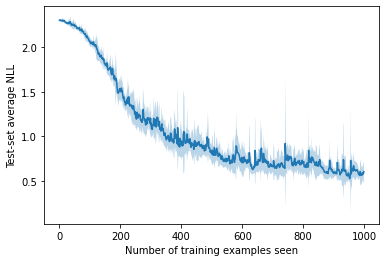

In [39]:
fig, ax = plt.subplots()
ax.plot(fdekf_mean)
ax.fill_between(
    jnp.arange(fdekf_mean.shape[0]),
    fdekf_mean - fdekf_std,
    fdekf_mean + fdekf_std,
    alpha=0.3
)
ax.set_xlabel('Number of training examples seen')
ax.set_ylabel('Test-set average NLL');

# 5. SGD

## 5.1 Hyperparam Tuning

In [40]:
@jit
def compute_loss_and_updates_sgd(state, batch_images, batch_labels):
    def loss_fn(params):
        logits = state.apply_fn(params, batch_images)
        loss = jnp.mean(optax.softmax_cross_entropy_with_integer_labels(logits=logits, labels=batch_labels))
        return loss, logits

    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, logits), grads = grad_fn(state.params)
    return grads

In [41]:
def train_and_evaluate_model(state, X_train, y_train):
    @jit
    def apply_updates(state, updates):
        return state.apply_gradients(grads=updates)

    def _step(carry, i):
        state = carry
        curr_image = X_train[i].reshape(1,28,28,1)
        curr_label = y_train[i]

        updates = compute_loss_and_updates_sgd(state, curr_image, curr_label)
        state = apply_updates(state, updates)
        nll = evaluate_neg_log_likelihood(state.params, unflatten_fn, apply_fn, test_ds)
        
        return state, nll
    
    state, nlls = lax.scan(_step, state, jnp.arange(len(X_train)))
    
    return state, nlls

In [42]:
def sgd_opt_fn(log_lr):
    tx = optax.sgd(jnp.power(10, log_lr))
    opt_state = train_state.TrainState.create(apply_fn=apply_fn, params=flat_params, tx=tx)
    _, nlls = train_and_evaluate_model(opt_state, X_train[:1000], y_train[:1000])

    result = nlls.mean()
    
    if jnp.isnan(result):
        result = 1e6
    return -result

In [20]:
sgd_optimizer = BayesianOptimization(
    f=sgd_opt_fn,
    pbounds={'log_lr': (-6.0, 0.0)}
)

In [21]:
sgd_optimizer.maximize(
    init_points=20,
    n_iter=20,
)

|   iter    |  target   |  log_lr   |
-------------------------------------
| 1         | -2.333    | -0.8656   |
| 2         | -2.302    | -3.104    |
| 3         | -2.357    | -0.6193   |
| 4         | -2.303    | -5.729    |
| 5         | -2.303    | -5.747    |
| 6         | -2.333    | -0.864    |
| 7         | -2.302    | -2.402    |
| 8         | -2.302    | -3.237    |
| 9         | -2.303    | -2.26     |
| 10        | -2.332    | -0.8874   |
| 11        | -2.303    | -3.719    |
| 12        | -2.302    | -2.505    |
| 13        | -2.302    | -2.96     |
| 14        | -2.303    | -5.526    |
| 15        | -2.303    | -2.324    |
| 16        | -2.303    | -2.137    |
| 17        | -2.303    | -5.902    |
| 18        | -2.318    | -1.148    |
| 19        | -2.303    | -5.723    |


KeyboardInterrupt: ignored

In [ ]:
# 'log_lr': -1.2630062347890139
print(sgd_optimizer.max)

{'target': -0.9550855159759521, 'params': {'log_lr': -1.2630062347890139}}


## 5.2 Test-Set NLL Evaluation

In [43]:
def evaluate_model_sgd(state, X, y, key=0, n_steps=1_000, n_iter=10):
    if isinstance(key, int):
        key = jr.PRNGKey(key)

    def _step(_, key):
        indx = jr.choice(key, len(X), (n_steps,))
        X_curr, y_curr = X[indx], y[indx]
        _, nlls = train_and_evaluate_model(state, X_curr, y_curr)
        return nlls, nlls
    
    keys = jr.split(key, n_iter)
    carry = jnp.zeros((n_steps,))
    _, nlls = lax.scan(_step, carry, keys)
    mean, std = nlls.mean(axis=0), nlls.std(axis=0)

    return mean, std

In [44]:
log_lr = -1.2630062347890139

tx = optax.sgd(jnp.power(10, log_lr))
opt_state = train_state.TrainState.create(apply_fn=apply_fn, params=flat_params, tx=tx)
# _, sgd_nlls = train_and_evaluate_model(opt_state, X_train[:1000], y_train[:1000])

In [45]:
sgd_mean, sgd_std = evaluate_model_sgd(opt_state, X_train, y_train)

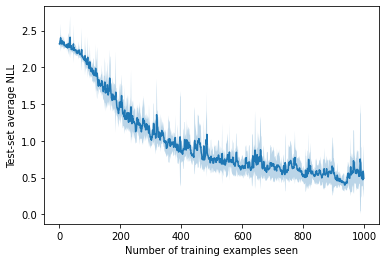

In [46]:
fig, ax = plt.subplots()
ax.plot(sgd_mean)
ax.fill_between(
    jnp.arange(sgd_mean.shape[0]),
    sgd_mean - sgd_std,
    sgd_mean + sgd_std,
    alpha=0.3
)
ax.set_xlabel('Number of training examples seen')
ax.set_ylabel('Test-set average NLL');

# 6. Model Comparison

In [48]:
results = {
    'sgd': (sgd_mean, sgd_std),
    'fdekf': (fdekf_mean, fdekf_std),
    'os_lofi': (os_lofi_mean, os_lofi_std),
    'fs_lofi': (fs_lofi_mean, fs_lofi_std)
}

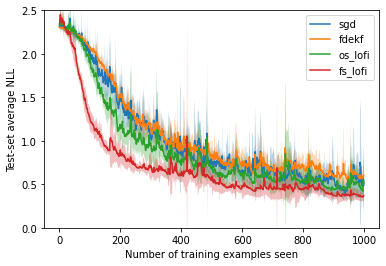

In [50]:
fig, ax = plt.subplots()
for key, val in results.items():
    mean, std = val
    ax.plot(mean, label=key)
    ax.fill_between(
        jnp.arange(mean.shape[0]),
        mean - std,
        mean + std,
        alpha=0.3
    )
ax.set_xlabel('Number of training examples seen')
ax.set_ylabel('Test-set average NLL')
ax.set_ylim(0.0, 2.5)
ax.legend();